In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from Categorization import Categorizer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import copy
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset, random_split
import imblearn
from collections import Counter

In [2]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.functional import one_hot
import imblearn
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.model_selection import StratifiedKFold, train_test_split
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
import os
from torch_explain.models.explainer import Explainer
import time
from torchmetrics.functional import precision_recall
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.linear_model import LassoCV
from torch_explain.logic.metrics import formula_consistency
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from func_timeout import func_set_timeout, func_timeout, FunctionTimedOut

In [3]:
mimicDF = pd.read_csv('../LEN_Test/data/StaticData.csv')
targetDF = mimicDF[['deathperiod']]

display(mimicDF['PatientID'].value_counts())

ids = mimicDF['PatientID']

display(ids)

mimicDF = mimicDF.drop(columns=['PatientID', 'deathperiod'])

categorisationTypes = {}

186706    7
108976    5
154357    4
194933    4
130738    3
         ..
108246    1
167548    1
193531    1
120875    1
131831    1
Name: PatientID, Length: 4873, dtype: int64

0       181199
1       167020
2       169463
3       183338
4       192665
         ...  
5257    106017
5258    186511
5259    188867
5260    115153
5261    131831
Name: PatientID, Length: 5262, dtype: int64

In [4]:
mimicDF.head()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,NaN,0.0,3.0,3.0
1,2,0,75.00,4,2,NaN,0.0,0.0,1.0,NaN,1.0
2,16,0,51.92,4,2,NaN,0.0,NaN,0.0,NaN,2.0
3,12,0,51.73,-13,4,2.0,2.0,NaN,0.0,NaN,0.0
4,7,0,62.07,0,3,0.0,2.0,NaN,1.0,NaN,0.0


In [5]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,3311.000000,5227.000000,2254.000000,5261.000000,1294.000000,5212.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,1.987315,0.674957,0.696983,1.017297,3.238022,0.768611
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.374066,0.892066,1.051290,1.263514,0.706116,1.140061
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [6]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 4778 containing NaN values


### Missing values dealt with by filling with the mode.

In [7]:
for col in mimicDF:
    mimicDF[col] = mimicDF[col].fillna(mimicDF[col].mode()[0])

In [8]:
mimicDF

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,0.0,0.0,3.0,3.0
1,2,0,75.00,4,2,3.0,0.0,0.0,1.0,3.0,1.0
2,16,0,51.92,4,2,3.0,0.0,0.0,0.0,3.0,2.0
3,12,0,51.73,-13,4,2.0,2.0,0.0,0.0,3.0,0.0
4,7,0,62.07,0,3,0.0,2.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5257,120,1,36.61,5,10,3.0,3.0,4.0,0.0,3.0,0.0
5258,13,0,53.90,12,4,3.0,0.0,0.0,0.0,3.0,1.0
5259,4,0,58.93,18,5,3.0,1.0,0.0,4.0,3.0,0.0
5260,16,0,68.98,-4,3,1.0,2.0,0.0,0.0,3.0,0.0


In [9]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.00000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,2.36279,0.670468,0.298556,1.017104,3.058533,0.761307
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.19465,0.890785,0.769595,1.263472,0.364759,1.137079
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,2.00000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,3.00000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.00000,1.000000,0.000000,2.000000,3.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000


In [10]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 0 containing NaN values


#### Replaced NaN values with average of respective columns

In [11]:
dataNeedingEncodingDF = mimicDF[['los', 'age', 'comorbidity', 'sofa']]

### Fixing high age range

In [12]:
ageWithoutOutliers = dataNeedingEncodingDF['age'][dataNeedingEncodingDF['age'] < 200]

dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))

dataNeedingEncodingDF.head()

C:\Users\benma\AppData\Local\Temp/ipykernel_25364/2166811324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))


,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,-13,4
4,7,62.07,0,3


#### Does clustering in 2d here help with classification? Moving up the values will mean jumping between categories which doesn't seem right. Unless there is something special about those few numbers in dark blue

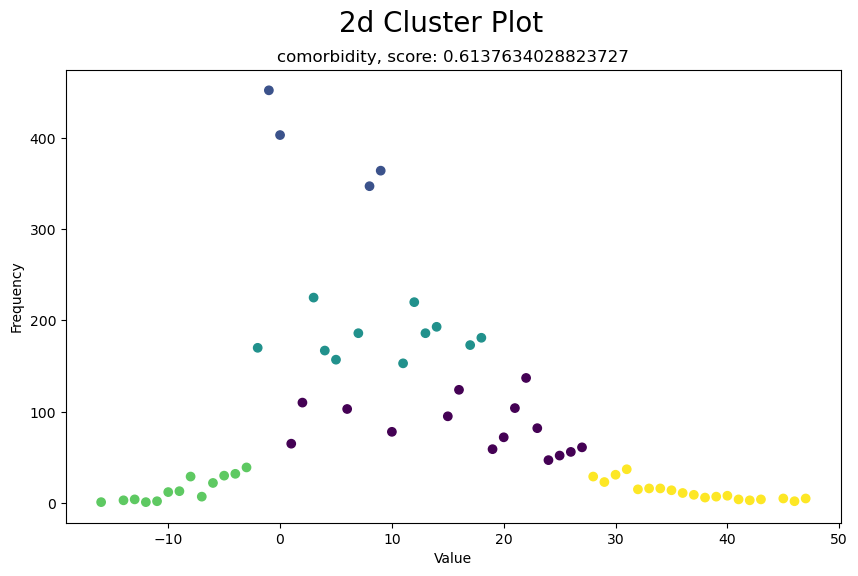

In [13]:
comorbidity = dataNeedingEncodingDF[['comorbidity']]

comorbidity = pd.DataFrame(data=list(zip(comorbidity.value_counts().index, comorbidity.value_counts().values)), columns=['comorbidity', 'count'])

comorbidity['comorbidity'] = comorbidity['comorbidity'].astype(str).apply(lambda x: x[1:-2]).astype(np.int64)

comorbidityDF = AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(comorbidity))

sil_x = np.dstack((comorbidity['comorbidity'], comorbidity['count']))[0]

score = silhouette_score(sil_x, comorbidityDF)

fig = plt.figure(figsize=(10,6), dpi=100)
fig.suptitle("2d Cluster Plot", fontsize=20)

plt.scatter(comorbidity['comorbidity'], comorbidity['count'], c=comorbidityDF)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"comorbidity, score: {score}")
plt.show()

In [14]:
dataNeedingEncodingDF

,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,-13,4
4,7,62.07,0,3
...,...,...,...,...
5257,120,36.61,5,10
5258,13,53.90,12,4
5259,4,58.93,18,5
5260,16,68.98,-4,3


# Graphically representing the categorisation

In [15]:
cat = Categorizer(dataNeedingEncodingDF)

clusters = 3

cat.kBins(bins=clusters)
cat.agglomerative(n_clusters=clusters)
cat.kMeans(n_clusters=clusters)

# cat.display()

,los,age,comorbidity,sofa
0,0,2,1,1
1,0,2,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
5257,2,0,0,2
5258,0,1,1,0
5259,0,1,1,1
5260,0,1,0,0


In [16]:
pd.set_option('display.max_rows', 1000)

In [20]:
# categories = {0: 'low', 1: 'medium', 2: 'high'}

# type = list(cat.categorizationTypes.keys())[0]

# tempDF = copy.copy(cat.categorizationTypes[type])


# tempDF = tempDF.apply(lambda x: x.map(categories))

# tempDF.head()

# tempDF = pd.get_dummies(tempDF)

# tempDF.head()


,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,sofa_low,sofa_medium
0,0,1,0,1,0,0,0,0,1,0,1,0
1,0,1,0,1,0,0,0,1,0,0,1,0
2,0,1,0,0,0,1,0,1,0,0,1,0
3,0,1,0,0,0,1,0,1,0,0,1,0
4,0,1,0,0,0,1,0,1,0,0,1,0


In [17]:
# categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

categories = {0: 'low', 1: 'medium', 2: 'high'}



for type in cat.categorizationTypes:

    cat.categorizationTypes[type][['respiration','coagulation','liver','renal','cardiovascular','cns']] = mimicDF[['respiration','coagulation','liver','renal','cardiovascular','cns']]

    for col in cat.categorizationTypes[type].columns:
        cat.categorizationTypes[type][col] = cat.categorizationTypes[type][col].map(categories)
    
    

    cat.categorizationTypes[type]['gender'] = mimicDF['gender'].map({0:'male', 1:'female'})

    cat.categorizationTypes[type] = pd.get_dummies(cat.categorizationTypes[type])

    display(cat.categorizationTypes[type])

,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_high,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
5258,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5260,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_high,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,1,0,1,0
5258,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5260,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_high,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0
5258,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5260,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


### TODO Do we want to standardise the data before categorising?

If another point (eg an outlier) is added to the dataset, then this could push the other points away from their original categorisation. Need outlier detection? 

In [18]:
targetDF.describe()

,deathperiod
count,5262.000000
mean,0.896047
std,7.338713
min,-29.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,107.000000


In [19]:
targetDF

,deathperiod
0,-1
1,2
2,-1
3,-1
4,-1
...,...
5257,-1
5258,-1
5259,-1
5260,-1


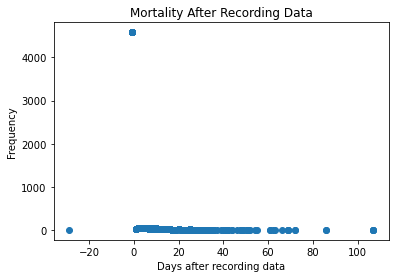

In [20]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()))
plt.xlabel("Days after recording data")
plt.ylabel("Frequency")
plt.title("Mortality After Recording Data")
plt.show()

In [21]:
targetDF['deathperiod'] = targetDF['deathperiod'].apply(lambda x: x if x > -1 else -1)

In [22]:
targetDiedDF = targetDF[targetDF['deathperiod'] > -1]
targetNoDeathDF = targetDF[targetDF['deathperiod'] == -1].apply(lambda x: x+1.0)

In [23]:
targetDiedDF.shape

(678, 1)

In [24]:
targetNoDeathDF.shape

(4584, 1)

In [25]:
bins = 3

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
targetCategorisedDF = pd.DataFrame(data=est.fit_transform(targetDiedDF), columns=['deathperiod'])

targetCategorisedDF['deathperiod'] = targetCategorisedDF['deathperiod'].apply(lambda x: x + 1)

targetCategorisedDF.set_index(targetDiedDF.index, inplace=True)

targetCategorisedDF.head()

,deathperiod
1,1.0
7,3.0
16,2.0
36,3.0
40,2.0


In [26]:
targetNoDeathDF.head()

,deathperiod
0,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [27]:
combinedTargetDF = targetCategorisedDF.merge(targetNoDeathDF, how='outer', left_index=True, right_index=True).rename(columns={'deathperiod_x': 'deathperiod'})

withDeath = combinedTargetDF.iloc[:,0]
noDeath = combinedTargetDF.iloc[:,1]

newTargetDF = withDeath.fillna(noDeath)

newTargetDF = newTargetDF.astype(np.int64)

newTargetDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

In [28]:
simpleNewTargetDF = targetDF['deathperiod'].apply(lambda x: 0 if x < 0 else 1)

simpleNewTargetDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

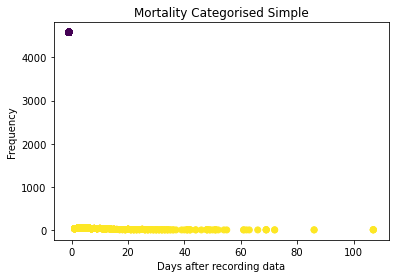

In [29]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=simpleNewTargetDF)
plt.xlabel("Days after recording data")
plt.ylabel("Frequency")
plt.title("Mortality Categorised Simple")
plt.show()

In [30]:
simpleNewTargetDF.value_counts()

0    4584
1     678
Name: deathperiod, dtype: int64

In [31]:
mapped = cat.categorizationTypes['agglomerative']

mapped['Mortality14Days'] = simpleNewTargetDF

mapped['PatientID'] = ids

mapped = mapped.set_index('PatientID')

mapped

,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male,Mortality14Days
PatientID,,,,,,,,,,,,,,,,,,,,,
181199,0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
167020,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,1,1
169463,0,1,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
183338,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
192665,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106017,1,0,0,0,1,0,0,0,1,1,...,1,0,0,0,0,1,0,1,0,0
186511,0,1,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
188867,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [32]:
dataname = "staticData.csv"

mapped.to_csv(f"./categorisedData/{dataname}")

In [33]:
# plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=newTargetDF)
# plt.xlabel("Days after recording data")
# plt.ylabel("Frequency")
# plt.title("Mortality Categorised kBins")
# plt.show()

### Here without the -1 value so we can see the variance of the rest

#### We can see that using a uniform distribution would create a heavily imbalanced dataset

#### Show how performance changes when bins changes

In [34]:
# tempDF = targetDF[targetDF['deathperiod'] > -1]

# plt.scatter(tempDF['deathperiod'], tempDF['deathperiod'].map(tempDF['deathperiod'].value_counts()), c=newTargetDF[newTargetDF> 0])
# plt.show()

In [35]:
# newTargetDF.value_counts()

In [36]:
# targetCategorisedDF

In [37]:
# class FOL:

#     def __init__(self, features):
#         self.features = features

#     def __repr__(self):
#         out = "\n("
#         for i in range(len(self.features)):
#             feature = self.features[i]
#             if feature.sign == 'OR':
#                 out += ") \nOR \n("
#                 continue
#             out += f"{feature}"
#             if i+1 < len(self.features) and self.features[i+1].sign != 'OR':
#                 out += " AND "
#         out += ")\n"
#         return out


In [38]:
# class Feature:

#     def __init__(self, sign=None, number=None, name=None):
#         self.sign = sign
#         self.name = name
#         self.number = number

#     def __repr__(self):
#         out = ""
#         if self.sign is not None:
#             if self.sign == -1:
#                 out += "NOT_"
#             # out += f"{self.sign} "
#         # if self.number is not None:
#         #     out += f"{self.number} "
#         if self.name is not None:
#             out += f"{self.name}"
#         return out

In [39]:
# def convertFeaturesToColumnNames(explanation, columns):
    
#     features = [x for x in explanation.split(" ") if x != '&']

#     featureList = []

#     for feature in features:
#         f = Feature()
#         if feature[0] == '|':
#             f.sign = 'OR'
#             featureList.append(f)
#             continue
#         if feature[-1] == ')':
#             feature = feature[:-1]
#         if feature[0] == '(':
#             feature = feature[1:]
#         if feature[0] == '~':
#             f.sign = -1
#         else:
#             f.sign = 1
#         f.number = int(feature[-2:])
#         f.name = columns[f.number]
#         featureList.append(f)
    
#     # print(featureList)

#     fol = FOL(featureList)

#     # print(fol)

#     return fol
        

#     # return [columns[x] for x in featureNums]

In [40]:
# mapped = cat.categorizationTypes['agglomerative']

# mapped['deathperiod'] = newTargetDF

# mapped['PatientID'] = ids

# mapped = mapped.set_index('PatientID')

# mapped

In [41]:
# dataname = "staticData.csv"

# mapped.to_csv(f"./categorisedData/{dataname}")